In [1]:
using thesis, PRMaps
using Healpix
using Plots
using Statistics
using LsqFit
using Distributions
using LaTeXStrings
using JLD2

import Stripeline as Sl
import Pandas as Pd

In [2]:
function run_scaling(
    tel_angles,
    sky_model::String,
    nside::Int,
    setup::PRMaps.Setup
)
    
    strip = Pd.query(Pd.read_pickle("../instruments/lspe_strip_instrument.pkl"), :(frequency==43.0))
    signal = get_foreground_maps(strip, sky_model, nside)[1]

    camera = Sl.CameraAngles()
    ideal, _ = makeIdealMapIQU(camera, signal, setup)
    obs_ideal = HealpixMap{Float64, RingOrder}(ideal.i.resolution.nside)
    polDegreeMap!(obs_ideal, ideal.q, ideal.u)        

    maps_pol = HealpixMap[]

    for i in tel_angles
        m, _ = makeErroredMapIQU(camera, i, signal, setup)
        buffer = HealpixMap{Float64, RingOrder}(m.i.resolution.nside)
        polDegreeMap!(buffer, m.q, m.u)        
        push!(maps_pol, buffer)
    end

    error = [ (obs_ideal - errored) for errored in maps_pol]

    error_hist = [ i[isfinite.(i)] for i in error]

    distro_fit = [ fit(Cauchy, data) for data in error_hist ]

    sigma = [ scale(distro) for distro in distro_fit ]

    return sigma

end

run_scaling (generic function with 1 method)

In [3]:
nside = 512
sky_model = "s0"
obs_days = 5
 
setup = PRMaps.Setup(
    sampling_freq_Hz = 50.,
    total_time_s = 24. * 3600. * obs_days
    )
nothing

fit_params = []

Any[]

In [4]:
errored_angles_deg = [0.25/60, 0.5/60, 1.0/60, 5.0/60]
omega_wobble_deg = [0.0, 90.0, 180.0, 270.0]

errored_angles_arcsec = [15, 30, 60, 300]

xdata = log10.(range(minimum(errored_angles_arcsec), stop=maximum(errored_angles_arcsec), length=10000))

nothing

In [5]:
xlabel = L"\textrm{Configuration \ angle \ bias} \ [\log_{10}(\textrm{arcsec})]"
ylabel = L"\textrm{F.W.H.M. \ of \ the \ error \ distribution} \ [\log_{10}(\mu K)]"
nothing

In [6]:
tel_angs_altitude = [Sl.TelescopeAngles(wheel2ang_0_rad = deg2rad(i)) for i in errored_angles_deg]
tel_angs_ground = [Sl.TelescopeAngles(wheel3ang_0_rad = deg2rad(i)) for i in errored_angles_deg]
tel_angs_fork = [Sl.TelescopeAngles(forkang_rad = deg2rad(i)) for i in errored_angles_deg]
tel_angs_0 = [Sl.TelescopeAngles(zVAXang_rad = deg2rad(i), ωVAXang_rad = deg2rad(0.0)) for i in errored_angles_deg]
tel_angs_90 = [Sl.TelescopeAngles(zVAXang_rad = deg2rad(i), ωVAXang_rad = deg2rad(90.0)) for i in errored_angles_deg]
tel_angs_180 = [Sl.TelescopeAngles(zVAXang_rad = deg2rad(i), ωVAXang_rad = deg2rad(180.0)) for i in errored_angles_deg]
tel_angs_270 = [Sl.TelescopeAngles(zVAXang_rad = deg2rad(i), ωVAXang_rad = deg2rad(270.0)) for i in errored_angles_deg]
nothing

In [26]:
rerun_simulation = false

false

In [46]:
if rerun_simulation
    # THETA 0
    result_altitude = run_scaling(tel_angs_altitude, sky_model, nside, setup) * 2 
    save_object("../results/scaling/altitude.jld2", result_altitude)

    # PHI 0
    result_ground = run_scaling(tel_angs_ground, sky_model, nside, setup) * 2
    save_object("../results/scaling/ground.jld2", result_ground)

    # FORK
    result_fork = run_scaling(tel_angs_fork, sky_model, nside, setup) * 2
    save_object("../results/scaling/fork.jld2", result_fork)

    # WOBBLE
    result_0 = run_scaling(tel_angs_0, sky_model, nside, setup) * 2
    result_90 = run_scaling(tel_angs_90, sky_model, nside, setup) * 2
    result_180 = run_scaling(tel_angs_180, sky_model, nside, setup) * 2
    result_270 = run_scaling(tel_angs_270, sky_model, nside, setup) * 2

    save_object("../results/scaling/wobble_0.jld2", result_0)
    save_object("../results/scaling/wobble_90.jld2", result_90)
    save_object("../results/scaling/wobble_180.jld2", result_180)
    save_object("../results/scaling/wobble_270.jld2", result_270)
else
    result_altitude = load_object("../results/scaling/altitude.jld2")
    result_ground = load_object("../results/scaling/ground.jld2")
    result_fork = load_object("../results/scaling/fork.jld2")
    result_0 = load_object("../results/scaling/wobble_0.jld2")
    result_90 = load_object("../results/scaling/wobble_90.jld2")
    result_180 = load_object("../results/scaling/wobble_180.jld2")
    result_270 = load_object("../results/scaling/wobble_270.jld2") 
end
result = [result_altitude, result_ground, result_fork, result_0, result_90, result_180, result_270]
nothing

In [61]:
markers = [:rect :utriangle :star :circle :circle :circle :circle]
labels = []
nothing

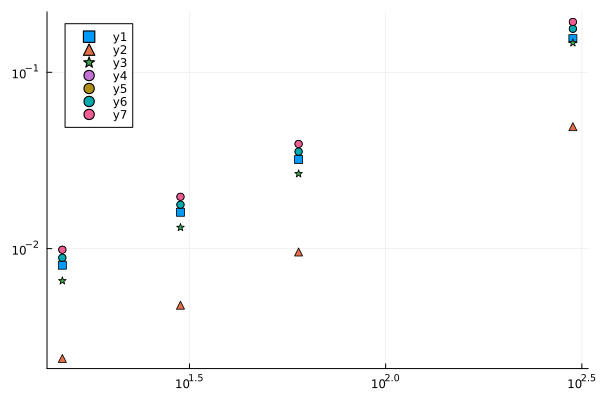

In [68]:
scatter(errored_angles_arcsec, result, markershape = markers, yaxis=:log, xaxis=:log)

# Model used to fit

The error is fitted using:

$\log\epsilon = p_1 \log^2 x + p_2 \log x + p_3$

where x is the bias in the configuration angles

In [29]:
# @. model_linear(x,p) =  p[1]*x^2 + p[2]*x + p[3]
@. model_linear(x,p) =  p[2]*x + p[3]

model_linear (generic function with 1 method)

# Altitude offset

In [30]:
log_error = log10.(result_altitude)
log_angle = log10.(errored_angles_arcsec)
fit_linear = curve_fit(model_linear, log_angle, log_error, [0.0, 0.5, 1.0])
push!(fit_params, fit_linear.param)

8-element Vector{Any}:
 [0.0, 0.9869417968558835, -3.252417221085606]
 [0.0, 1.010475051749719, -3.8127146675506247]
 [0.0, 1.0386530526640199, -3.4115134988326314]
 [0.0, 0.9976465913059083, -3.2245562092250597]
 [0.0, 0.9921424103321331, -3.1716109290202774]
 [0.0, 0.9978102237713727, -3.2245720284628647]
 [0.0, 0.9927037650118832, -3.1727671804681057]
 [0.0, 0.9869417968558835, -3.252417221085606]

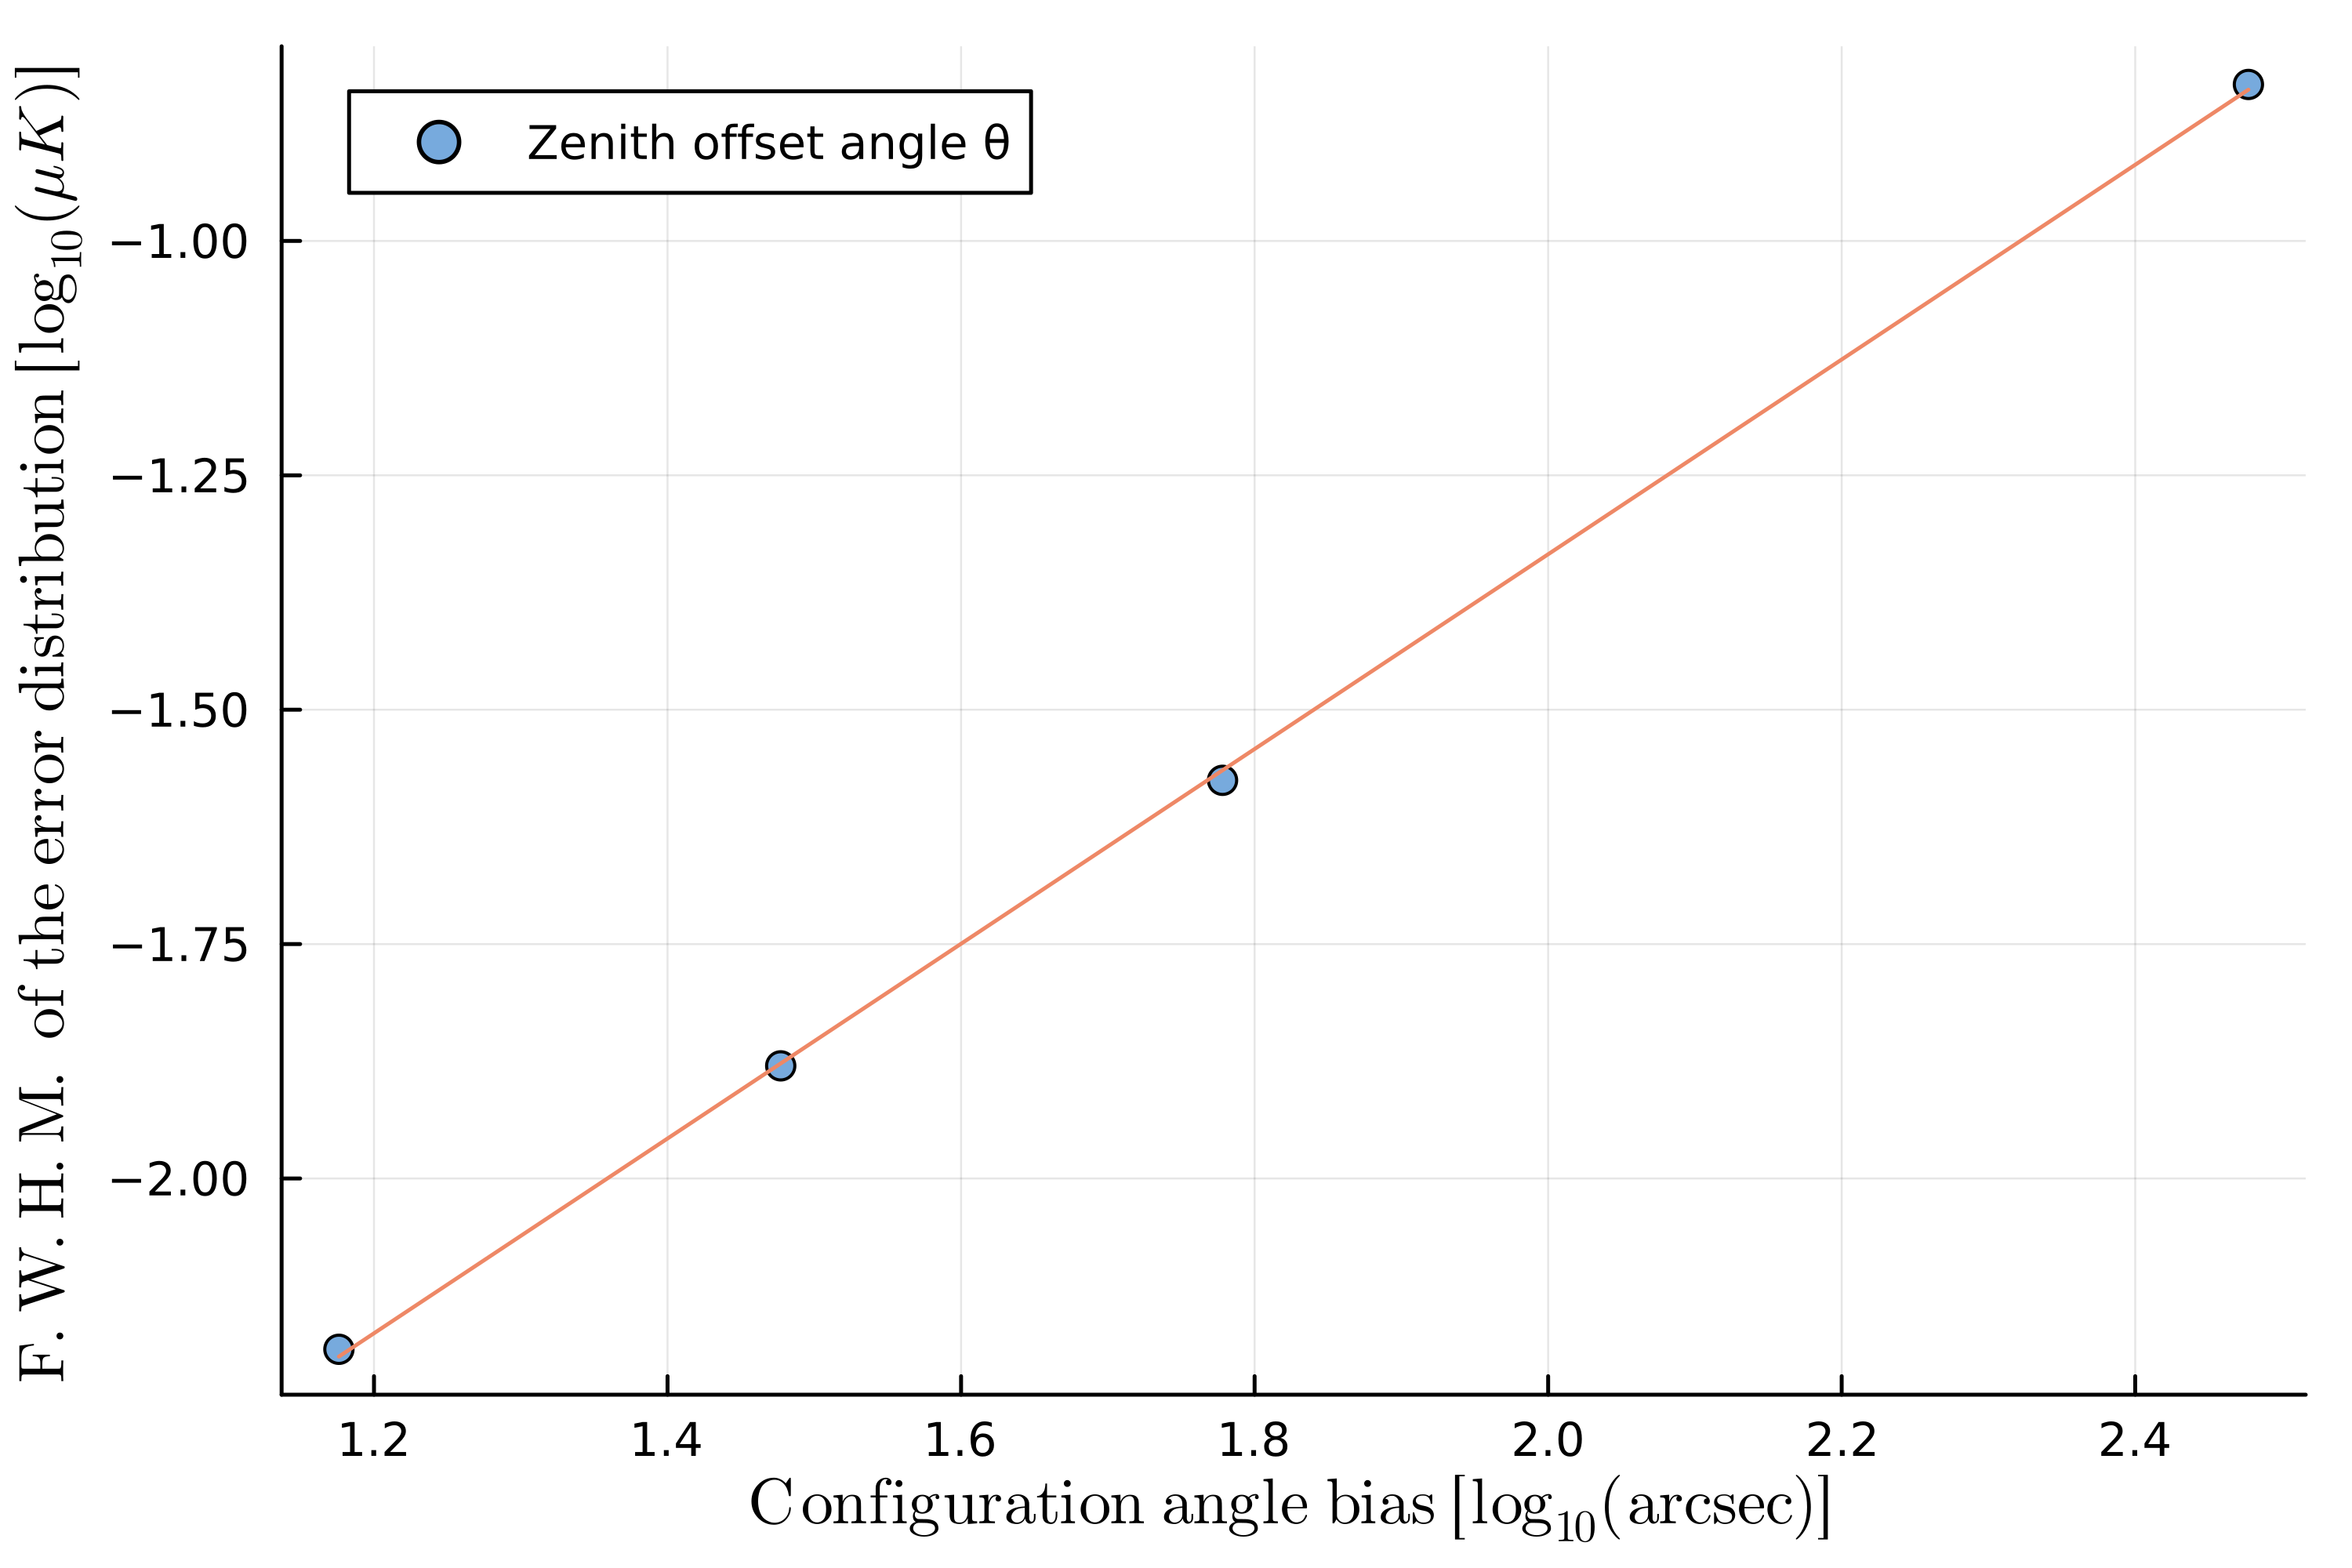

In [45]:
p = plot(linewidth = 1.5, marker = :circle, palette = :tol_light, dpi = 500)
p = scatter!(log_angle, log_error, xlabel=xlabel, ylabel=ylabel, label = "Zenith offset angle θ")
p = plot!(xdata, model_linear(xdata, fit_linear.param), label = false)
#savefig("scaling/altitude.svg")

# Ground offset angle

In [32]:
log_error = log10.(result_ground)
log_angle = log10.(errored_angles_arcsec)
fit_linear = curve_fit(model_linear, log_angle, log_error, [0.0, 0.5, 1.0])
push!(fit_params, fit_linear.param)

9-element Vector{Any}:
 [0.0, 0.9869417968558835, -3.252417221085606]
 [0.0, 1.010475051749719, -3.8127146675506247]
 [0.0, 1.0386530526640199, -3.4115134988326314]
 [0.0, 0.9976465913059083, -3.2245562092250597]
 [0.0, 0.9921424103321331, -3.1716109290202774]
 [0.0, 0.9978102237713727, -3.2245720284628647]
 [0.0, 0.9927037650118832, -3.1727671804681057]
 [0.0, 0.9869417968558835, -3.252417221085606]
 [0.0, 1.010475051749719, -3.8127146675506247]

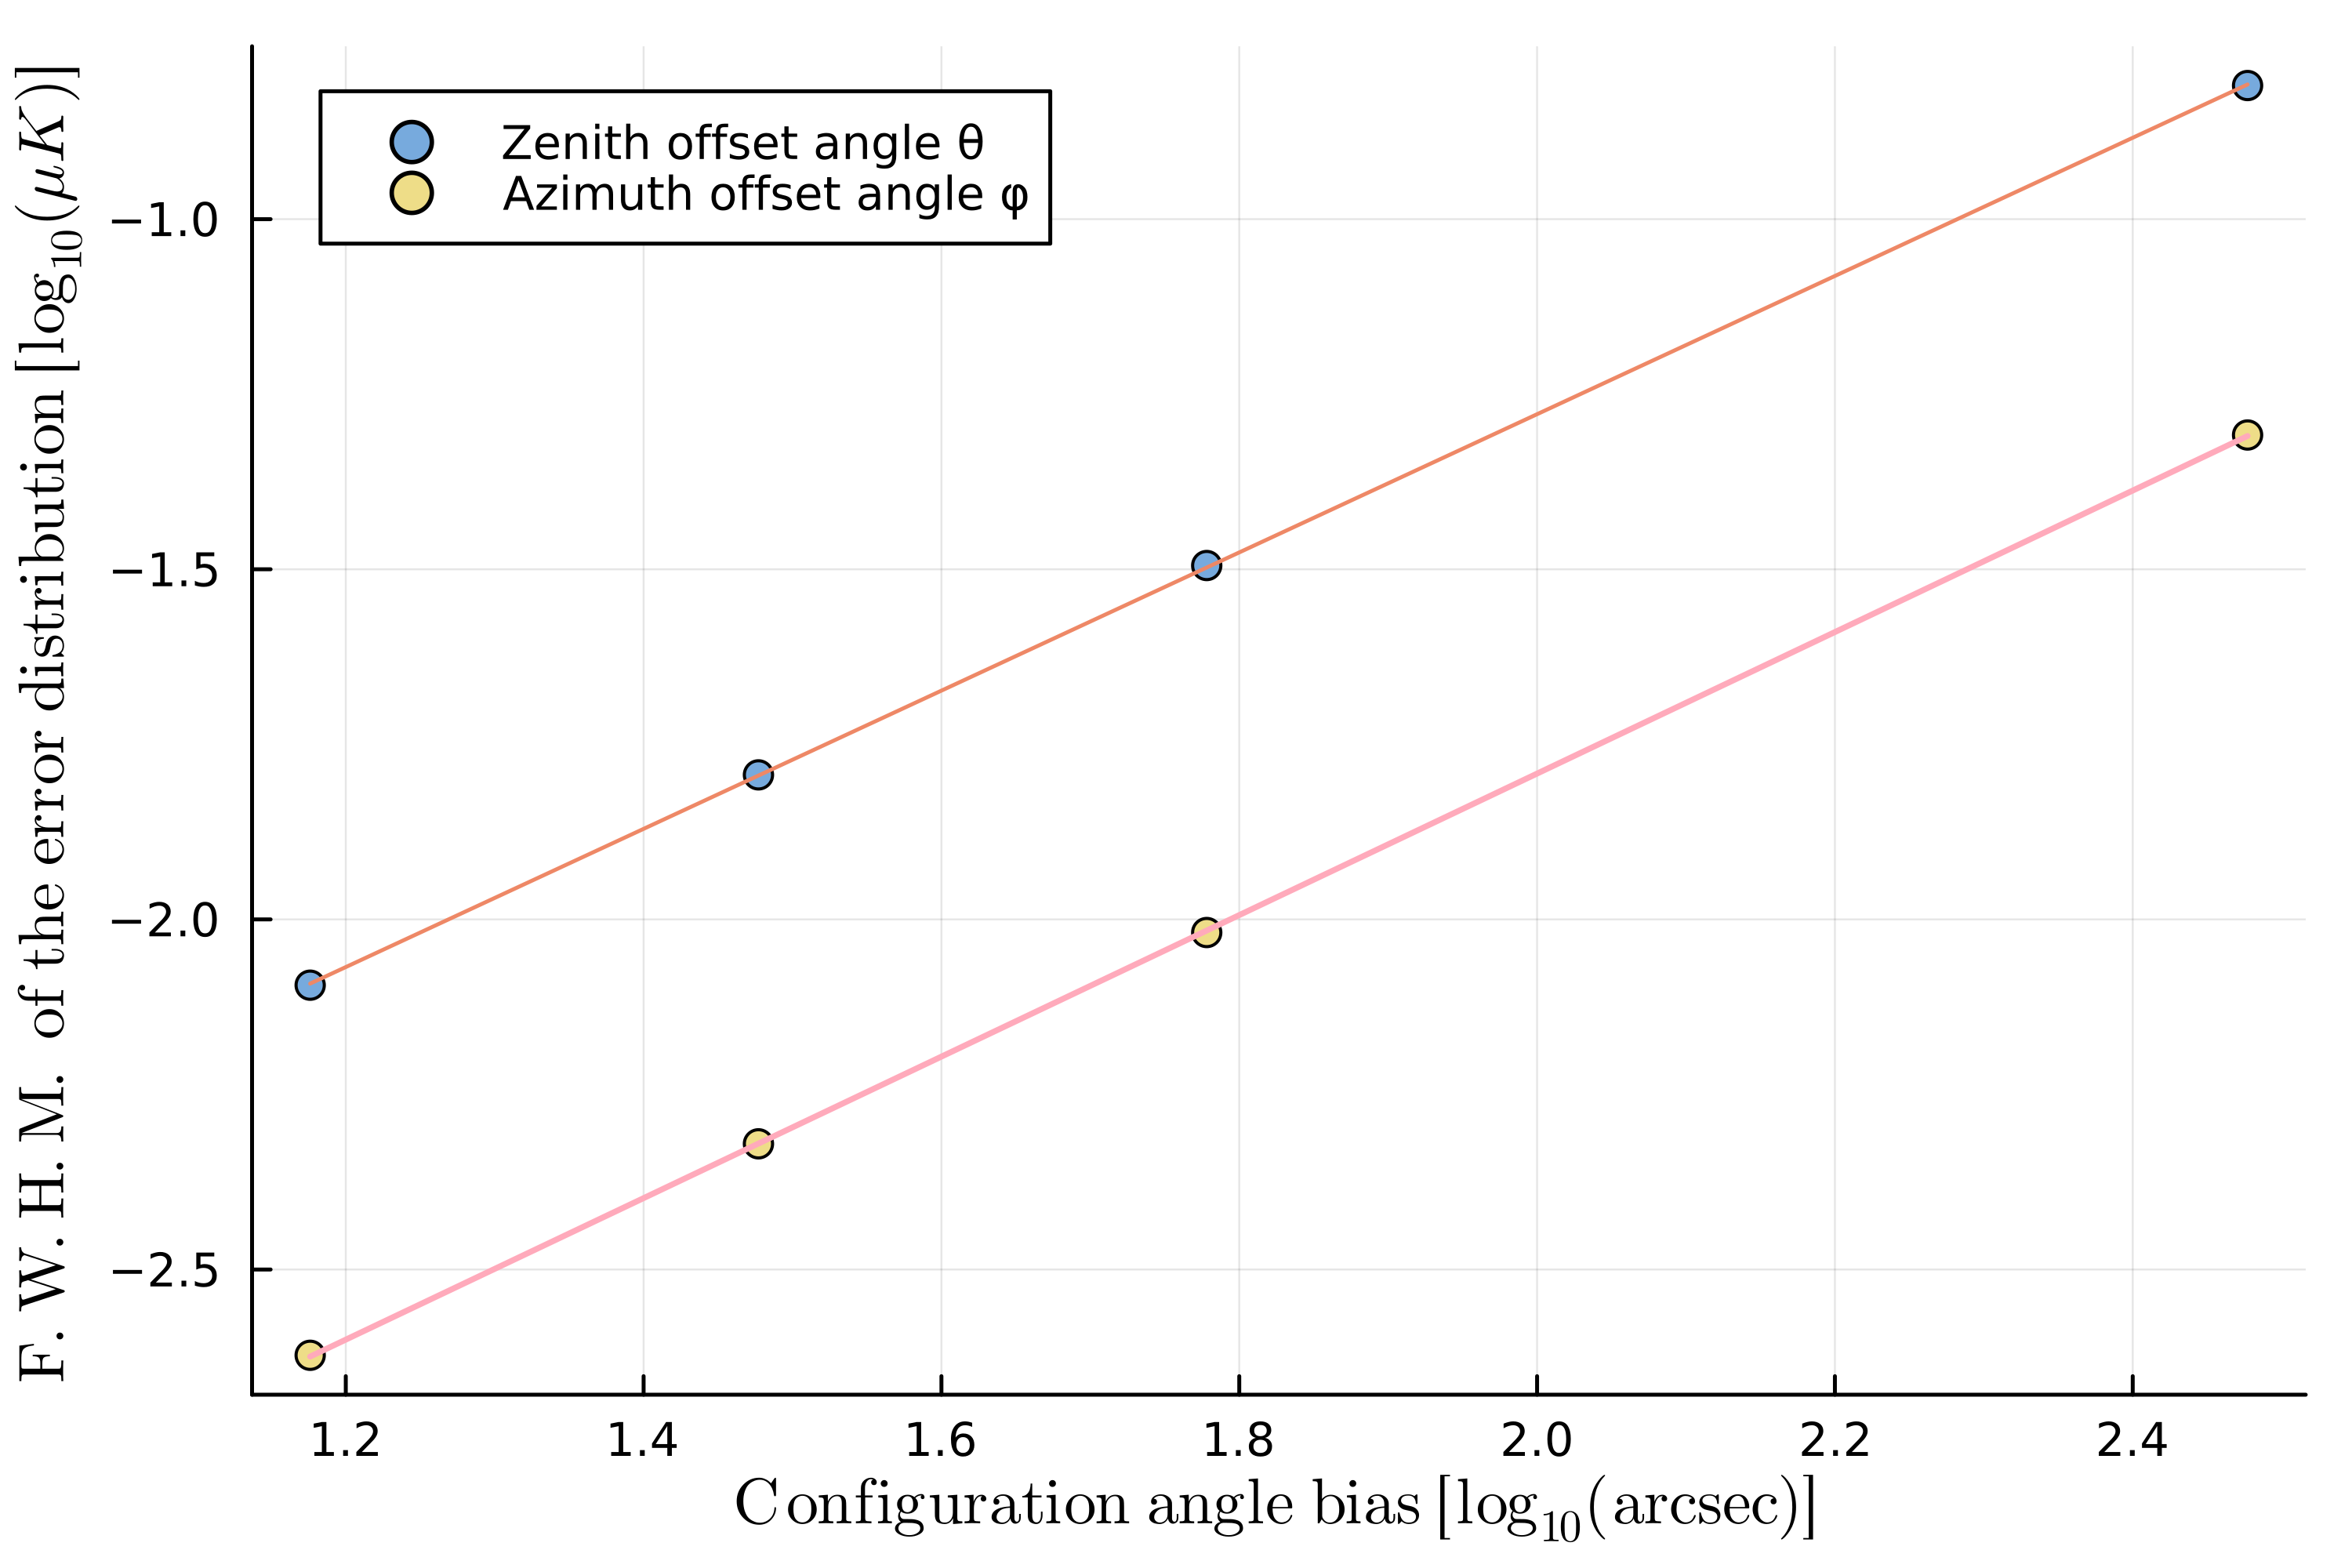

In [33]:
p = scatter!(log_angle, log_error, xlabel=xlabel, ylabel=ylabel, label = "Azimuth offset angle φ")
p = plot!(xdata, model_linear(xdata, fit_linear.param), label = false, linewidth = 1.5, palette = :tol_light, dpi = 500)

# Fork angle

In [34]:
log_error = log10.(result_fork)
log_angle = log10.(errored_angles_arcsec)
fit_linear = curve_fit(model_linear, log_angle, log_error, [0.0, 0.5, 1.0])
push!(fit_params, fit_linear.param)

10-element Vector{Any}:
 [0.0, 0.9869417968558835, -3.252417221085606]
 [0.0, 1.010475051749719, -3.8127146675506247]
 [0.0, 1.0386530526640199, -3.4115134988326314]
 [0.0, 0.9976465913059083, -3.2245562092250597]
 [0.0, 0.9921424103321331, -3.1716109290202774]
 [0.0, 0.9978102237713727, -3.2245720284628647]
 [0.0, 0.9927037650118832, -3.1727671804681057]
 [0.0, 0.9869417968558835, -3.252417221085606]
 [0.0, 1.010475051749719, -3.8127146675506247]
 [0.0, 1.0386530526640199, -3.4115134988326314]

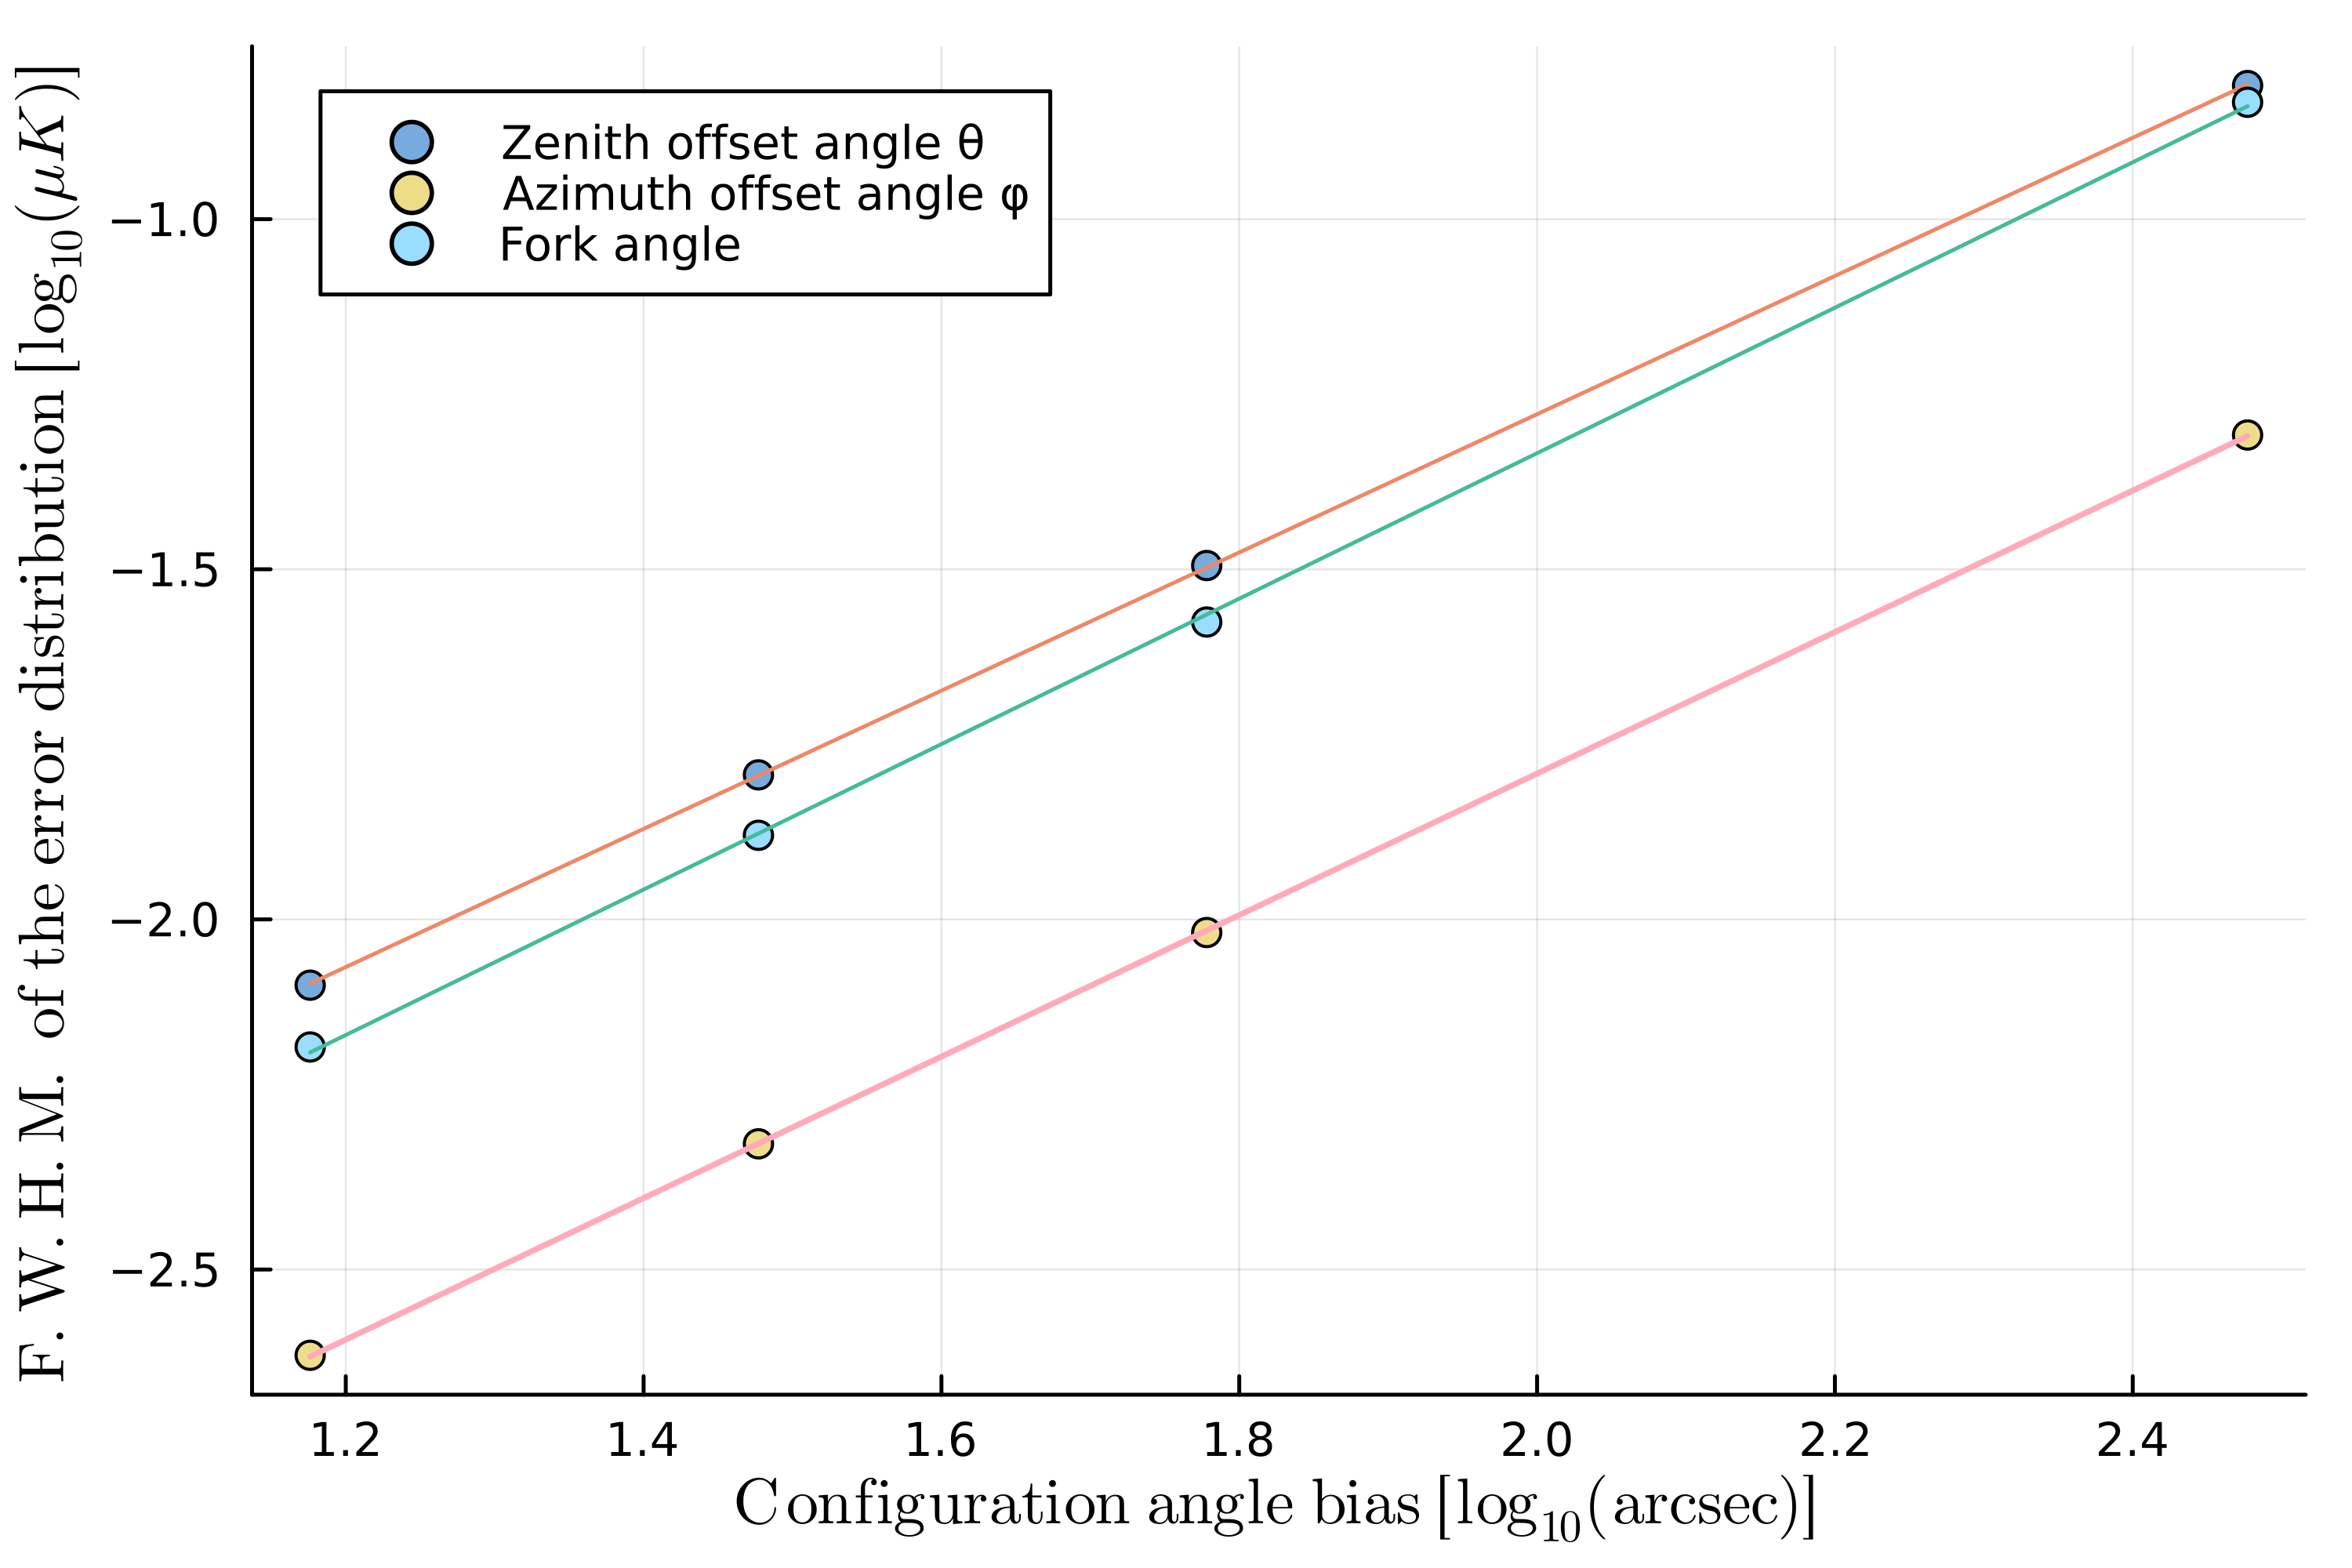

In [35]:
p = scatter!(log_angle, log_error, xlabel=xlabel, ylabel=ylabel, label = "Fork angle")
p = plot!(xdata, model_linear(xdata, fit_linear.param), label = false)

# Wobble angles

In [36]:
log_angle = log10.(errored_angles_arcsec)

log_error_0 = log10.(result_0)
log_error_90 = log10.(result_90)
log_error_180 = log10.(result_180)
log_error_270 = log10.(result_270)

fit_linear_0 = curve_fit(model_linear, log_angle, log_error_0, [0.0, 1.0, 1.0])
fit_linear_90 = curve_fit(model_linear, log_angle, log_error_90, [0.0, 1.0, 1.0])
fit_linear_180 = curve_fit(model_linear, log_angle, log_error_180, [0.0, 1.0, 1.0])
fit_linear_270 = curve_fit(model_linear, log_angle, log_error_270, [0.0, 1.0, 1.0])

push!(fit_params, fit_linear_0.param)
push!(fit_params, fit_linear_90.param)
push!(fit_params, fit_linear_180.param)
push!(fit_params, fit_linear_270.param)

14-element Vector{Any}:
 [0.0, 0.9869417968558835, -3.252417221085606]
 [0.0, 1.010475051749719, -3.8127146675506247]
 [0.0, 1.0386530526640199, -3.4115134988326314]
 [0.0, 0.9976465913059083, -3.2245562092250597]
 [0.0, 0.9921424103321331, -3.1716109290202774]
 [0.0, 0.9978102237713727, -3.2245720284628647]
 [0.0, 0.9927037650118832, -3.1727671804681057]
 [0.0, 0.9869417968558835, -3.252417221085606]
 [0.0, 1.010475051749719, -3.8127146675506247]
 [0.0, 1.0386530526640199, -3.4115134988326314]
 [0.0, 0.9976465913059083, -3.2245562092250597]
 [0.0, 0.9921424103321331, -3.1716109290202774]
 [0.0, 0.9978102237713727, -3.2245720284628647]
 [0.0, 0.9927037650118832, -3.1727671804681057]

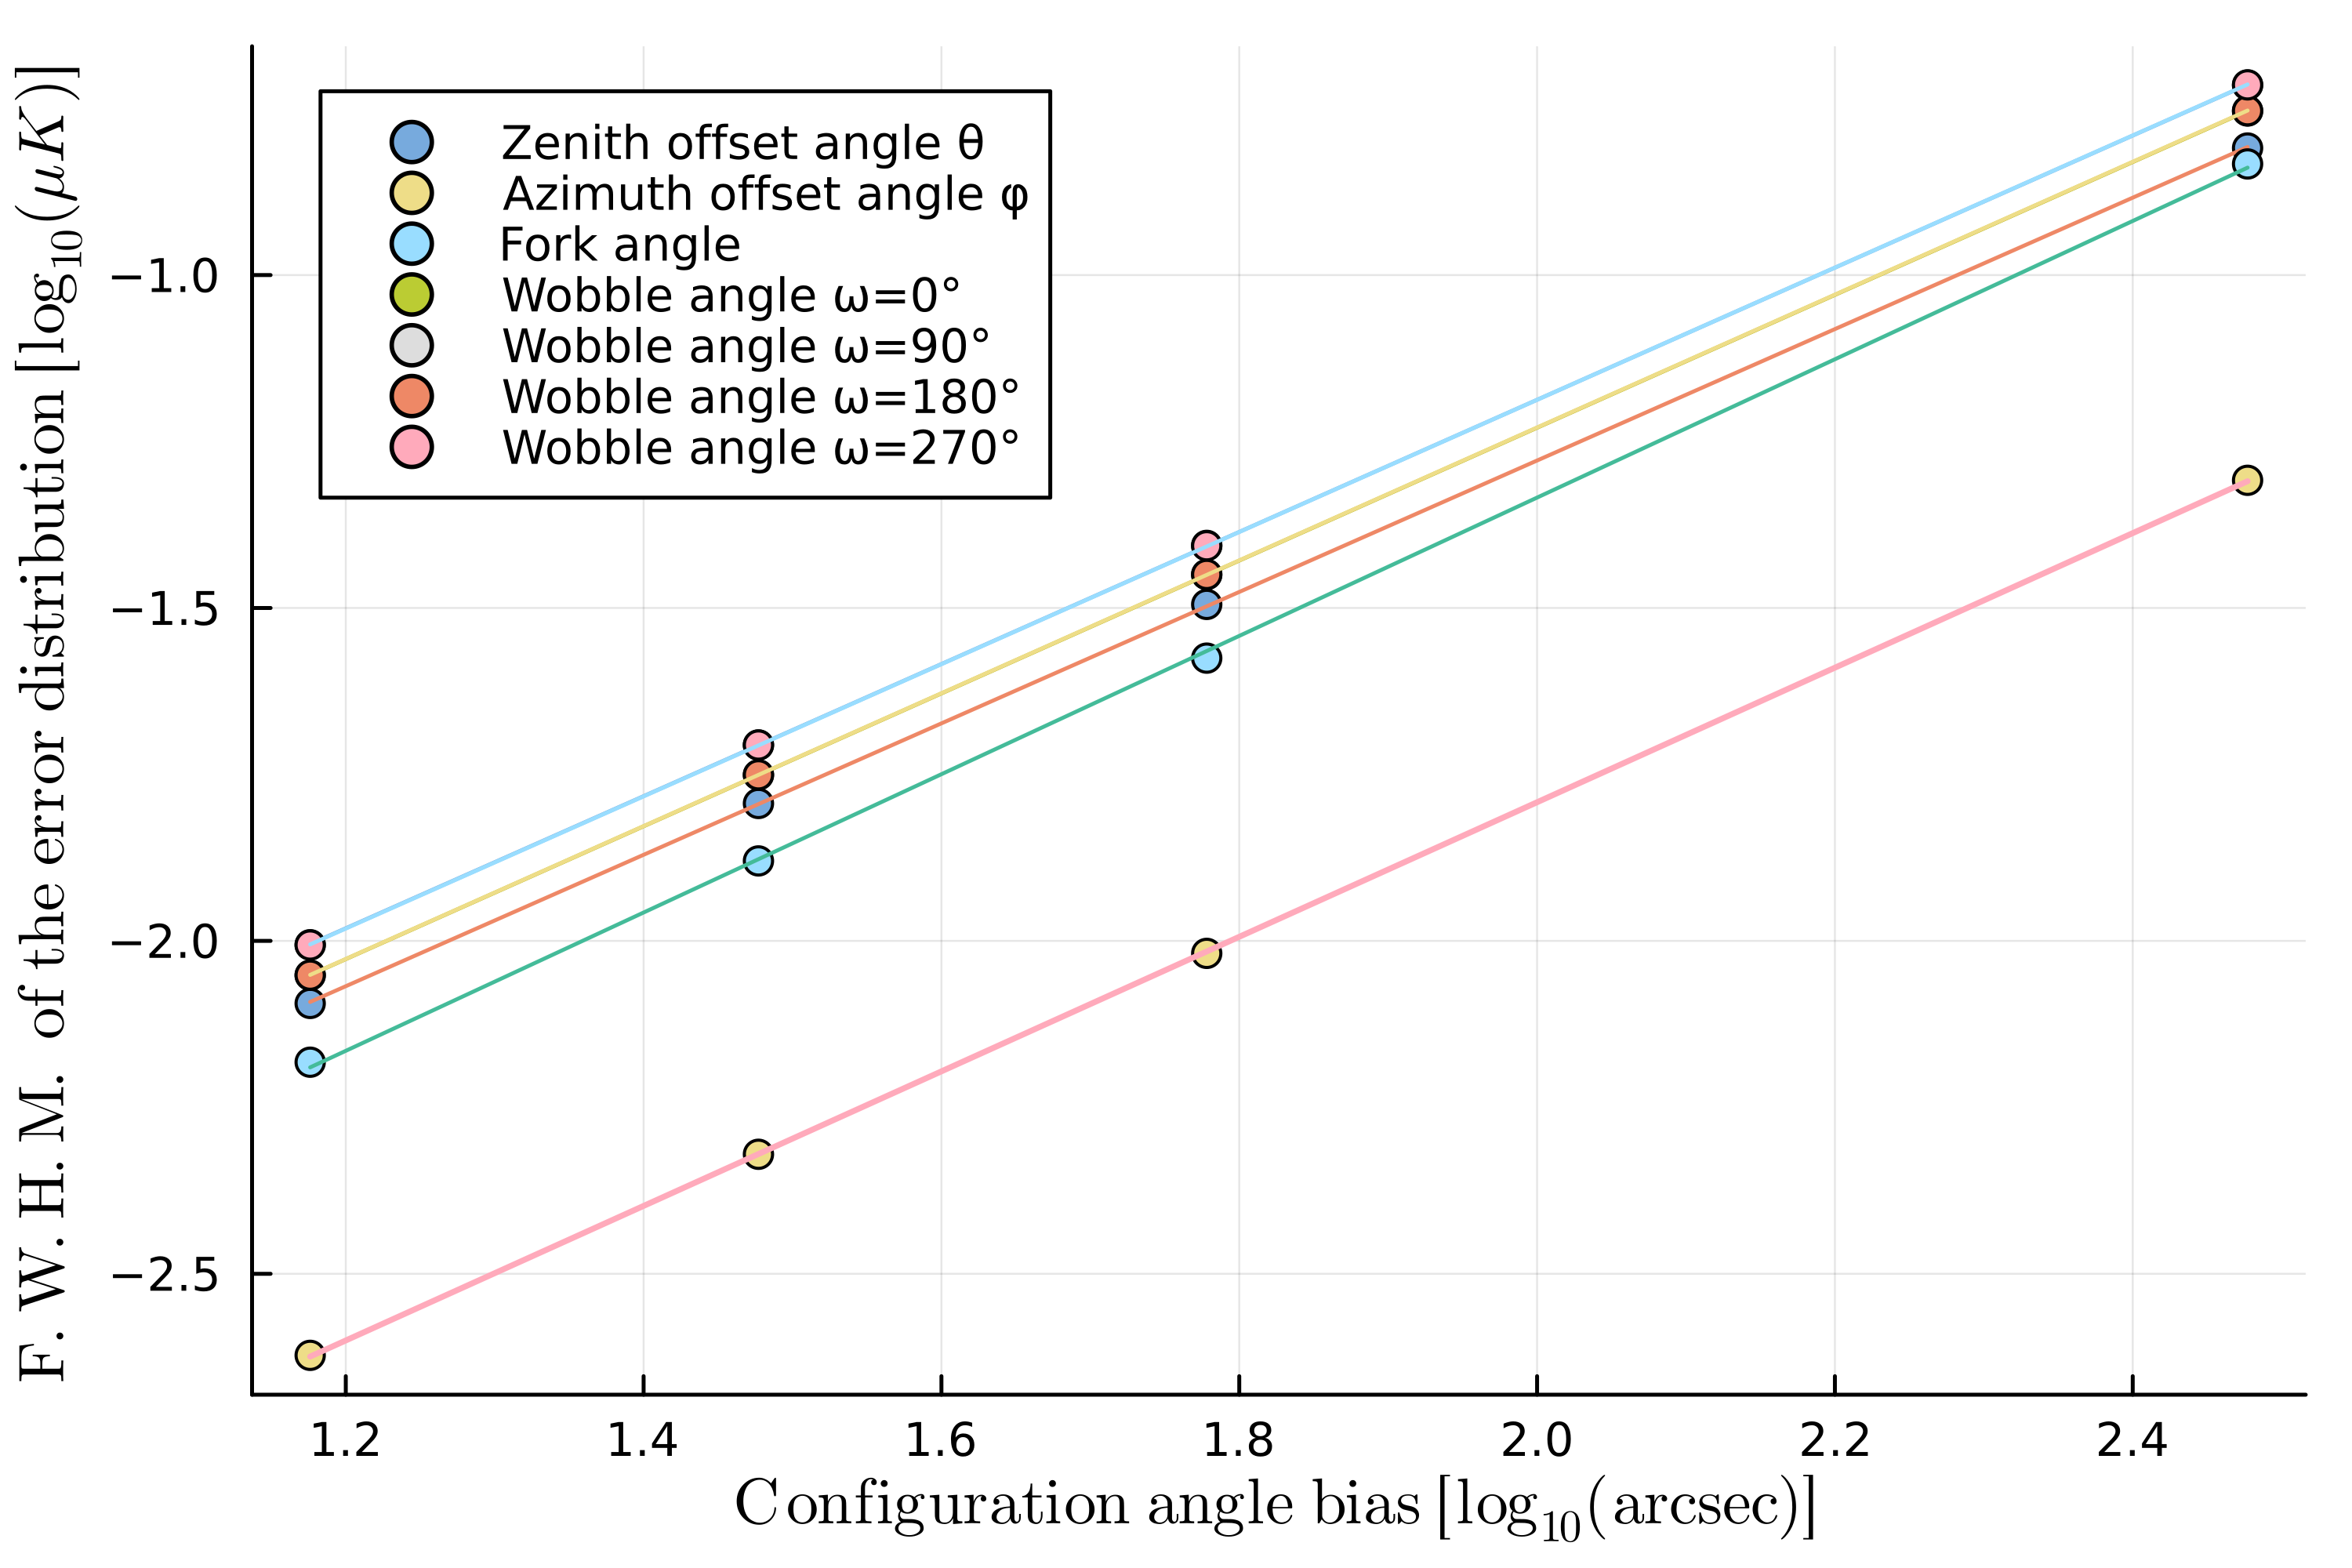

In [37]:

p = scatter!(log_angle, log_error_0, label = "Wobble angle ω=0°")
p = plot!(xdata, model_linear(xdata, fit_linear_0.param), label = false)

p = scatter!(log_angle, log_error_90, label = "Wobble angle ω=90°")
p = plot!(xdata, model_linear(xdata, fit_linear_90.param), label = false)

p = scatter!(log_angle, log_error_180, xlabel=xlabel, label = "Wobble angle ω=180°")
p = plot!(xdata, model_linear(xdata, fit_linear_180.param), label = false)

p = scatter!(log_angle, log_error_270, xlabel=xlabel, label = "Wobble angle ω=270°")
p = plot!(xdata, model_linear(xdata, fit_linear_270.param), label = false)

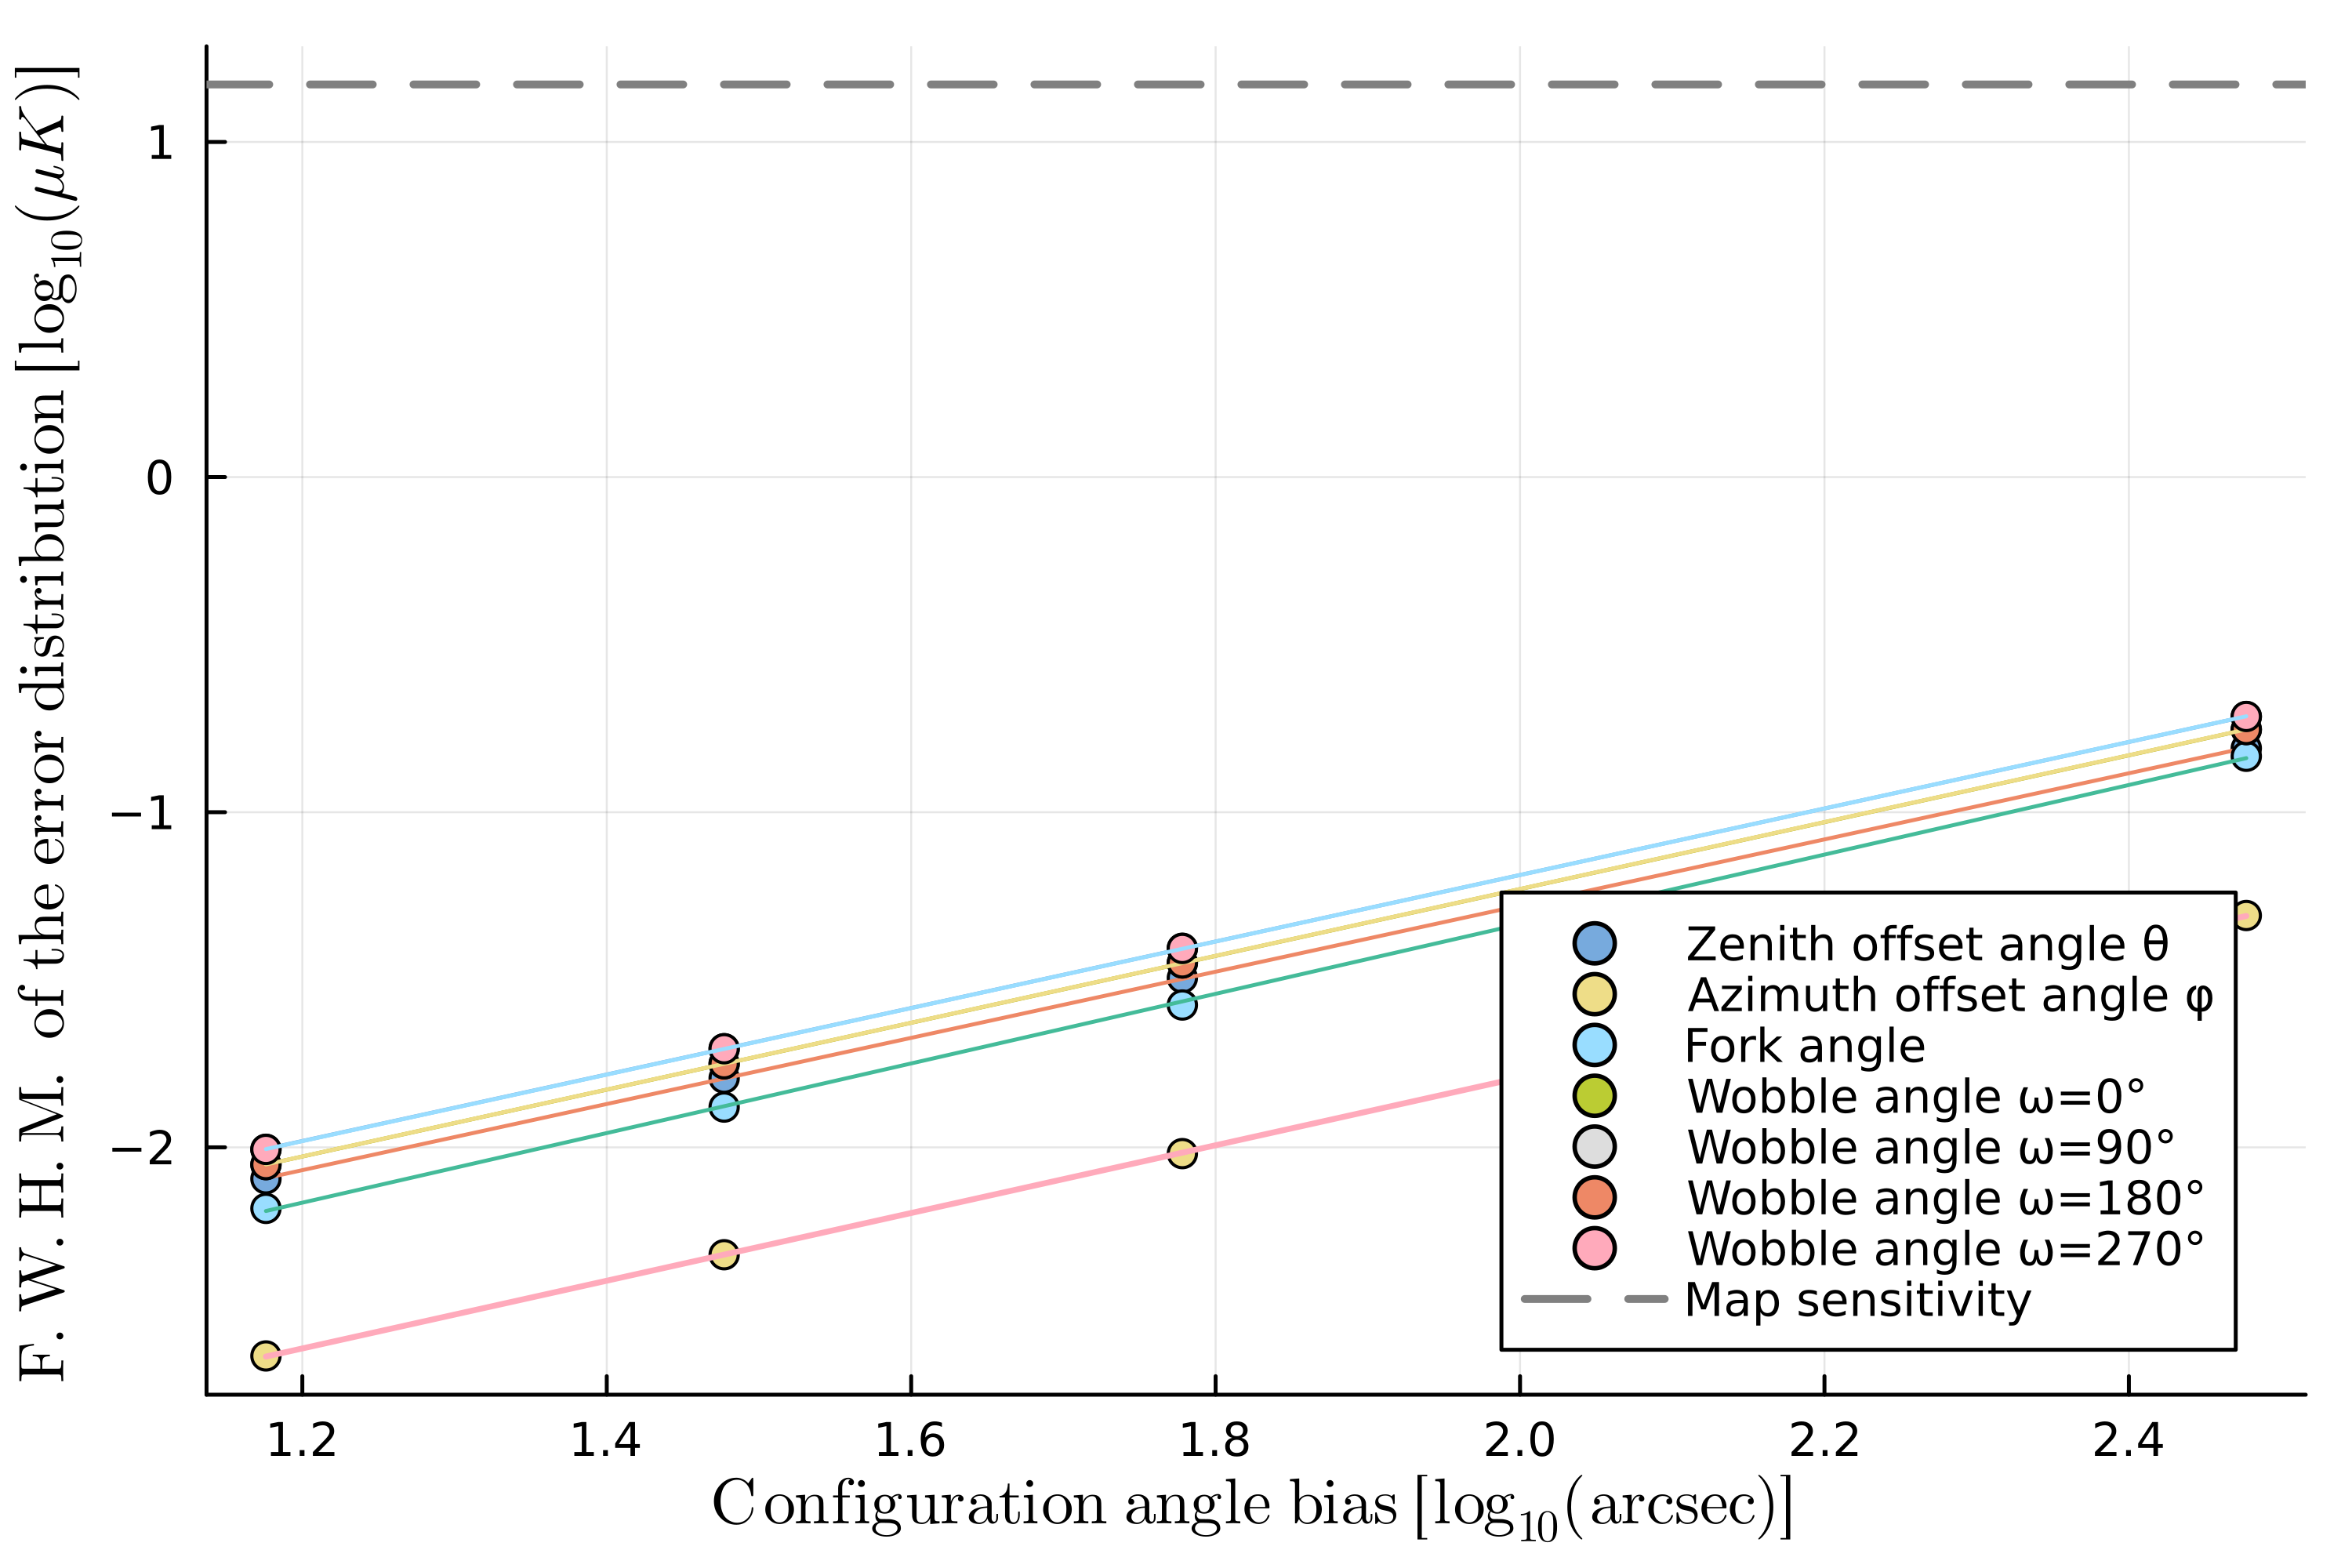

In [38]:
# Noise level associated to the instrument sensitivity at 43GHz for a 512 nside map
noise = 102 / (nside2resol(512) * (60 * 180) / π)
p = hline!([log10(noise)], label = "Map sensitivity", style=:dash, linewidth=2.0, color=:grey)

In [39]:
savefig("../results/scaling/scaling.pdf")

"/mnt/sda1/Università/Magistrale/Tesi/Master-Thesis-Pipeline/results/scaling/scaling.pdf"

In [40]:
fit_params

14-element Vector{Any}:
 [0.0, 0.9869417968558835, -3.252417221085606]
 [0.0, 1.010475051749719, -3.8127146675506247]
 [0.0, 1.0386530526640199, -3.4115134988326314]
 [0.0, 0.9976465913059083, -3.2245562092250597]
 [0.0, 0.9921424103321331, -3.1716109290202774]
 [0.0, 0.9978102237713727, -3.2245720284628647]
 [0.0, 0.9927037650118832, -3.1727671804681057]
 [0.0, 0.9869417968558835, -3.252417221085606]
 [0.0, 1.010475051749719, -3.8127146675506247]
 [0.0, 1.0386530526640199, -3.4115134988326314]
 [0.0, 0.9976465913059083, -3.2245562092250597]
 [0.0, 0.9921424103321331, -3.1716109290202774]
 [0.0, 0.9978102237713727, -3.2245720284628647]
 [0.0, 0.9927037650118832, -3.1727671804681057]